<a href="https://colab.research.google.com/github/emmanuellaanggi/disaster_tweet_sentiment/blob/master/Real_or_Not%3F_NLP_with_Disaster_Tweets_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DTSA 5511 PR Assignment



## Project Description

This project is a Kaggles competition and an assignment for DTSA 5511. As I said, the dataset I'm using here is from Kaggle and consists of tweets with labels indicating whether a tweet is a catastrophic tweet (a tweet describing a disaster). Through the data exploration and EDA in the first part, it is found that the data includes 7613 tweets (Text column) and labels (Target column), whether they are talking about a real disaster or not. There are 3271 lines for actual disasters and 4342 lines for non-actual disasters.

To give you a better understanding of this project, I have divided this project into two sections. In the first Section I will import the data and do some visual analysis. Finally, do some preprocessing operations on the data

Another section is a module for building models. Here I have built two models, the CNN model and the LSTM model. I compared the loss and acc of the two of them, and finally chose LSTM as my final model



In [5]:
#For Pre-Processing
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize
import os, re, csv, math, codecs


# For Training
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.utils.vis_utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

# For array, dataset, and visualizing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
np.random.seed(0)

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



I convert all words to numeric indices, to embedding indices in the pretrained model, and convert all missing words to 0,


In [6]:
print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('wiki-news-300d-1M.vec', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


999995it [01:47, 9322.49it/s] 

found 999995 word vectors


## Section 1 : Data Expore and EDA
As I said before, I will first import the data, the data includes 7613 tweets (Text column) and labels (Target column), there are 3271 lines to notify actual disasters, and 4342 lines to notify non-actual disasters

In [8]:
#load data
train_df = pd.read_csv('/content/DTSA551 Data/train.csv', sep=',', header=0)
test_df = pd.read_csv('/content/DTSA551 Data/test.csv', sep=',', header=0)
test_df = test_df.fillna('_NA_')

print("Number of training data ", train_df.shape[0])
print("Number of testing data: ", test_df.shape[0])

Number of training data  7613
Number of testing data:  3263


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


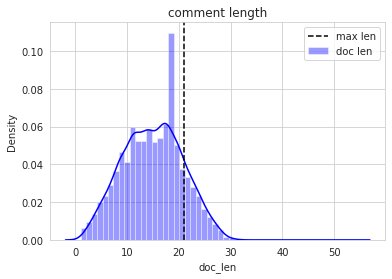

In [9]:
label_names = ["target"]
y_train = train_df[label_names].values
train_df['doc_len'] = train_df['text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)

sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

I started doing some preprocessing on the data, I used the tokenizer from tensorflow to tokenize the data


In [10]:
from sklearn.utils import shuffle 

raw_docs_train = train_df['text'].tolist()
raw_docs_test = test_df['text'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

pre-processing train data...


100%|██████████| 3263/3263 [00:00<00:00, 4245.31it/s]


tokenizing input data...
dictionary size:  28698


## Section 2 Model Build

Here I will build two models, namely the LSTM model and the CNN model. I used a more traditional parameter setting scheme including setting the batch size to 256 .

In [11]:
#training params
batch_size = 256 
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

I take the embedding matrix to determine the weight of each word in the training data. All words not in the fasttext pretrained model will be changed to 0. These are basically words with typos or names that are mostly not that important to the pattern. So it would be better to give it a weight of 0.

In [12]:
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 14232


In [13]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['doricreates' 'lpryzstk4u' 'ex8a5jyzm5' "'suspected" 'sitc' 'penneys'
 'calgarysun' 'gajtugaui7' 'u52rw9ji2r' 'o2jd4tbrwa']


#### 2.a LSTM Model 
I now start training the LSTM model. 

1. I use Sigmoid as the activation of the model output because this is a binary classification problem.


2. I initially set a Dropout rate of 0.3, as the initial value, this is not too large, and can also be used to prevent overfitting

3. Most importantly, when I fit the model, I introduced EarlyStopping, which effectively increases the training efficiency of the model, because with the increase of epoch, if the test loss is found to rise on the validation set, the model will stop training

Finally, the val_loss of the model is 0.4103, and the val accuracy is 0.8139

In [14]:
from keras.layers import BatchNormalization
import tensorflow as tf

model = tf.keras.Sequential()

model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))

model.add(Dropout(0.3))
model.add(Dense(32,activation='relu'))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 300)           8609700   
                                                                 
 dropout (Dropout)           (None, 21, 300)           0         
                                                                 
 dense (Dense)               (None, 21, 32)            9632      
                                                                 
 bidirectional (Bidirectiona  (None, 21, 128)          49664     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 21, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 21, 128)          9

In [16]:
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40
21/21 [==============================] - 46s 889ms/step - loss: 0.6866 - accuracy: 0.5812 - val_loss: 0.6755 - val_accuracy: 0.6594
Epoch 2/40
21/21 [==============================] - 17s 819ms/step - loss: 0.6242 - accuracy: 0.6791 - val_loss: 0.5189 - val_accuracy: 0.7693
Epoch 3/40
21/21 [==============================] - 20s 969ms/step - loss: 0.5309 - accuracy: 0.7572 - val_loss: 0.4715 - val_accuracy: 0.7863
Epoch 4/40
21/21 [==============================] - 14s 676ms/step - loss: 0.4871 - accuracy: 0.7880 - val_loss: 0.4419 - val_accuracy: 0.8100
Epoch 5/40
21/21 [==============================] - 14s 675ms/step - loss: 0.4653 - accuracy: 0.7925 - val_loss: 0.4199 - val_accuracy: 0.8078
Epoch 6/40
21/21 [==============================] - 14s 680ms/step - loss: 0.4482 - accuracy: 0.8030 - val_loss: 0.4164 - val_accuracy: 0.8126
Epoch 7/40
21/21 [==============================] - 14s 674ms/step - loss: 0.4440 - accuracy: 0.8063 - val_loss: 0.4257 - val_accuracy: 0.8113

evaluation on the training for each epoch

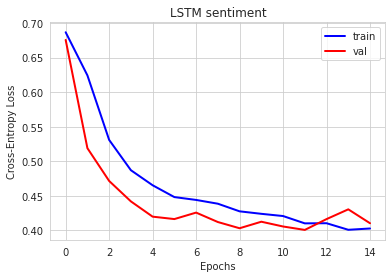

In [18]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

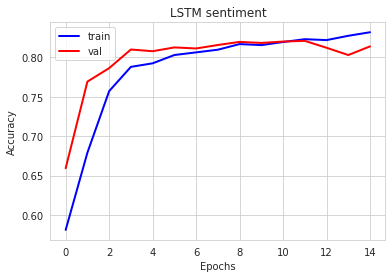

In [19]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

### 2.b CNN Model
Now I will train a CNN model. In order to better compare the model, I use similar parameters, the output activation is also set to sigmoid, and the loss function is also binary_crossentropy. But I set the dropout rate of the hidden node of the CNN model to 0.5, because through cross-validation, when the dropout of the hidden function is 0.5, the effect is good

In [21]:
# we don't want the model to overwrite, dont we?
keras.backend.clear_session()

In [24]:
#CNN architecture
from tensorflow import keras
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='sigmoid'))  
adam = tf.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

training CNN ...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 21, 300)           8609700   
                                                                 
 conv1d_4 (Conv1D)           (None, 21, 64)            134464    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 10, 64)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 10, 64)            28736     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 6

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [26]:
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40
21/21 [==============================] - 4s 148ms/step - loss: 0.6642 - accuracy: 0.6262 - val_loss: 0.5804 - val_accuracy: 0.7557
Epoch 2/40
21/21 [==============================] - 2s 115ms/step - loss: 0.5465 - accuracy: 0.7454 - val_loss: 0.4650 - val_accuracy: 0.7859
Epoch 3/40
21/21 [==============================] - 2s 117ms/step - loss: 0.4580 - accuracy: 0.8013 - val_loss: 0.4255 - val_accuracy: 0.8139
Epoch 4/40
21/21 [==============================] - 2s 116ms/step - loss: 0.4080 - accuracy: 0.8332 - val_loss: 0.4349 - val_accuracy: 0.8021
Epoch 5/40
21/21 [==============================] - 5s 224ms/step - loss: 0.3669 - accuracy: 0.8555 - val_loss: 0.4444 - val_accuracy: 0.8043
Epoch 6/40
21/21 [==============================] - 4s 177ms/step - loss: 0.3388 - accuracy: 0.8726 - val_loss: 0.4340 - val_accuracy: 0.8100


evaluation on the training for each epoch with this model

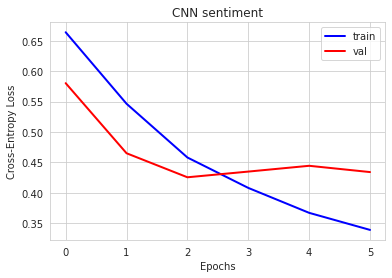

In [28]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

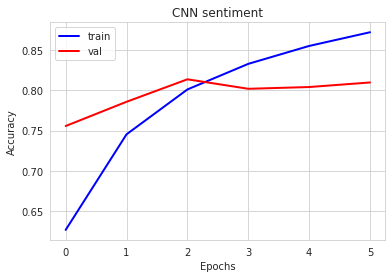

In [29]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

## Summary
After comparison, we can see that the LSTM model will perform better than the CNN model on this problem. The final validation loss of the LSTM model is about 0.41, and the validation accuracy is about 0.813. On the contrary, the validation loss of the CNN model is about 0.43 and the validation accuracy is about 0.810. So I ended up choosing LSTM as my final model